DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 10188
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 1138
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 778
    })
})


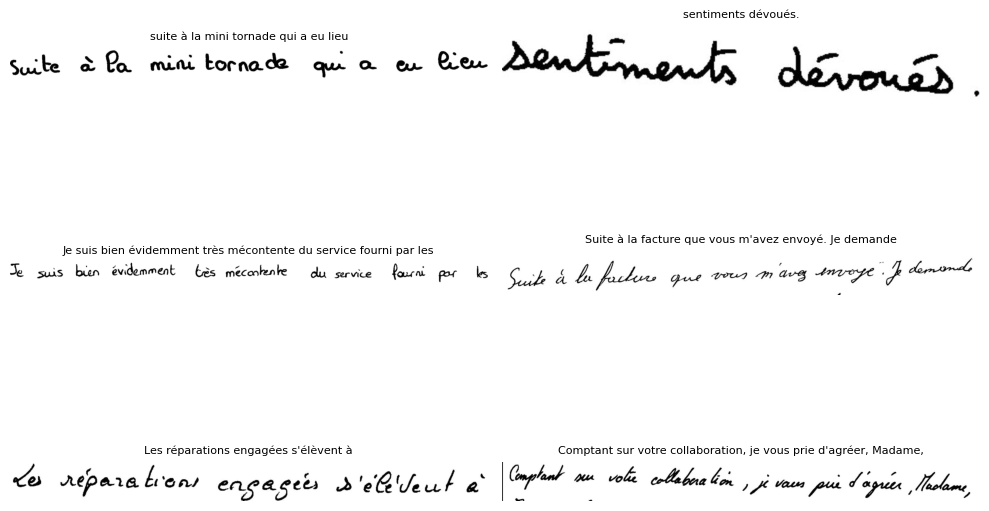

In [2]:
from matplotlib import pyplot as plt
from datasets import load_dataset
ds = load_dataset("Teklia/RIMES-2011-line")
print(ds)

def show_samples(dataset, num_samples=5, split="train"):
    samples = dataset[split].shuffle(seed=42).select(range(num_samples))  # Shuffle and select samples

    # Adjusting layout for better visualization
    num_cols = 2  # Display in two columns
    num_rows = (num_samples + 1) // num_cols  # Determine the number of rows

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 2.5))
    axes = axes.flatten()

    for i, example in enumerate(samples):
        image = example["image"]
        text = example["text"]

        axes[i].imshow(image.convert("L"), cmap="gray")  # Convert to grayscale
        axes[i].set_title(text, fontsize=8)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Show 6 random samples from the training set in a grid layout
show_samples(ds, num_samples=6, split="train")


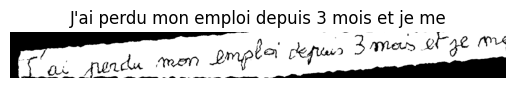

In [3]:
import torchvision.transforms as transforms
import torch
import numpy as np
import cv2
from PIL import Image

# Elastic Distortion Function
def elastic_transform(image, alpha=36, sigma=6):
    image = np.array(image)
    shape = image.shape
    dx = np.random.uniform(-1, 1, shape) * alpha
    dy = np.random.uniform(-1, 1, shape) * alpha
    smoothed_dx = cv2.GaussianBlur(dx, (17, 17), sigma)
    smoothed_dy = cv2.GaussianBlur(dy, (17, 17), sigma)
    
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + smoothed_dx).astype(np.float32)
    map_y = (y + smoothed_dy).astype(np.float32)
    
    distorted = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR)
    return Image.fromarray(distorted)

# Define final transform pipeline
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(degrees=5),  # Rotate ±5 degrees
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=5),  # Shift & Shear
    transforms.Lambda(lambda img: elastic_transform(img)),  # Apply elastic distortion
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brightness & Contrast changes
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Apply the updated transformation
sample_image = ds["train"][0]["image"]
augmented_image = train_transform(sample_image)

plt.imshow(augmented_image.squeeze(), cmap="gray")
plt.title(ds["train"][0]["text"])
plt.axis("off")
plt.show()
